#### Física de la Radioterapia
# Visualización de tratamientos de radioterapia
## Distribuciones de dosis absorbida
-----
*Este cuadereno modifica el código de los cuadernos de ejemplo del módulo [scikit-rt](https://scikit-rt.github.io/scikit-rt/examples.html)*

Los datos corresponden a una paciente real tratada en el Hospital de Fuenlabrada.

Han sido anonimizados de acuerdo a procedimientos validados.

**Objetivos**: 

* Mostrar elementos que aparecen en la planificación de un tratamiento de radioterapia

* Comprender las bases radiobiológicas del fraccionamiento de la dosis en radioterapia

## Fundamentos

En el tratamiento del cáncer de mama la radioterapia se emplea como tratamiento adyuvante a la cirugía. El tumor primario se extirpa y posteriormente se administra una dosis de radiación sobre el lecho tumoral y sobre el resto de la mama.

Definiendo un volumen de tratamiento que comprenda el lecho tumoral más un margen para incluir la posible enfermedad microscópica, la experiencia clínica apunta a que se tiene una alta probabilidad de éxito en el tratamiento si la dosis que se administra a ese volumen es de 60 Gy en 30 fracciones. Sobre el volumen que cubre toda la mama la dosis administrada debe ser de 50 Gy en 25 fracciones.

Los efectos adversos del tratamiento se cuantifican fundamentalmente por la dosis que reciba el pulmón ipsilateral, siendo un buen indicador predictivo el porcentaje de volumen que recibe una dosis de 20 Gy o superior en relación al volumen total de ese pulmón. Se considera tolerable un tratamiento en el que el volumen de pulmón que recibe 20 Gy es inferior al 25\% del volumen total. Otro efecto adverso es la aparición de radiodermitis por respuesta aguda de la piel a la radiación. Este efecto es controlado directamente por el oncólogo de radioterapia mediante revisiones en consulta durante el curso del tratamiento. En casos graves puede complicar el desarrollo del tratamiento obligando a parar y descansar durante un tiempo.

La manera convencional de aplicar el tratamiento es hacerlo de manera secuencial. Durante 25 fracciones se irradia la mama completa para generar una distribución de dosis todo lo uniforme posible procurando evitar el pulmón. El valor medio de esa distribución de dosis será de 50 Gy y la dispersión de la dosis debe ser tal que no más de un 5\% de la mama reciba más de 53.5 Gy ni más de un 5\% de la mama reciba menos de un 47.5 Gy, o dicho en términos relativos, el 95\% del volumen de la mama recibe al menos el 95\% de la dosis de prescripción y no más del 5\% del volumen de la mama recibe más del 107\% de la dosis de prescripción. A continuación se administraran otras cinco fracciones en las se procurará irradiar únicamente el volumen del lecho tumoral hasta que en este volumen se tenga una distribución de dosis con un valor medio de 60 Gy y de nuevo con una dispersión tal que se cumplan los criterios del 5\% aplicados al 95\% y al 107\% de la dosis de prescripción. En el argot de la radioterapia a la irradiación del volumen reducido se la denomina \textit{Boost} o Sobreimpresión.

Los avances técnicos han permitido realizar el tratamiento de manera concurrente. Los dos volúmenes se irradian en el mismo número de sesiones prescribiendo diferente dosis por sesión en cada uno de ellos. El tratamiento se acorta en el tiempo y la distribución de dosis se optimiza en mayor medida. La tendencia actual es realizar los tratamientos en menos fracciones.

En radioterapia la evaluación de los planes de tratamiento se realiza mediante mapas de dosis sobre cortes tomográficos e histogramas dosis volumen (DVH). Los oncólogos de radioterapia valoran la conformación de la dosis a los volúmenes de tratamiento y la protección de las estructuras de riesgo. Los DVH reducen la información de la distribución de dosis permitiendo evaluar la cantidad de volumen irradiado con una dosis dada. Lo habitual es presentarlos como histogramas acumulados invertidos de manera que cada punto del histograma nos da el volumen que recibe al menos la dosis considerada.

## Visualización de distribuciones de dosis

Esta primera parte del cuaderno emplea el módulo python `scikit-rt` para generar gráficos interactivos que permiten visualizar distribuciones de dosis empleadas en radioterapia.

Todos los sistemas de planificación de radioterapia ofrecen estas mismas representaciones. Los gráficos presentados aquí son menos versátiles que los de los programas de planificación pero básicamente tienen la misma funcionalidad.

Se asume que estamos corriendo el cuaderno en `jupyterlab`, bien sea en la distribución proporcionada en `mybinder` o en una instalación local.

### Subida de datos

En la barra lateral seleccionar el icono `File Browser`

Seleccionar la carpeta `data`

Pinchar sobre el icono `Upload Files`

Subir el archivo comprimido `MamaDer001.zip`

Importación de módulos y configuración de opciones

In [1]:
from skrt import Dose, Patient
from skrt.core import get_data_by_filename
import gdown

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Set scikit-rt viewer options.
options = {}
# Make display interactive ("no_ui": False) or non-interactive ("no_ui": True).
options["no_ui"] = False
# Include the interface for interactive zooming.
options["zoom_ui"] = not options["no_ui"]
# Use centre left of legend as reference point for fixing its location.
options["legend_loc"] = "center left"
# Set coordinates of legend reference point,
# in system where image axes extend from 0 to 1.
options["legend_bbox_to_anchor"] = (1.8, 0.5)
# Set figure size in inches.
options["figsize"] = (13, 6)
# Overlay default image annotation (slice z-coordinate), in white, at default position (top left or image).
options["annotate_slice"] = {"color": "white", "fontsize": 24}

Descargar y descomprimir los datos de la paciente

In [2]:
# Descargar los datos compartidos de Google Drive
url = 'https://drive.google.com/file/d/1ICECuwHhMBoMwioQ96-UpkV43v0kNneI/view?usp=sharing'
output = '../data/MamaDer001.zip'
gdown.download(url, output, quiet=False, fuzzy=True)

# Descomprimir el archivo zip
!bash ../shell_scripts/preparar_datos > /dev/null

Leer los datos de la paciente e identificar los planes de tratamiento y sus correspondientes distribuciones de dosis:
- *Secuencial*: compuesto por **mama** y **boost**. La combinación de ambos corresponde al plan **suma**
- *Concurrente*: plan **SIB** del inglés **S**imultaneous **I**ntegrated **B**oost

In [2]:
patient = Patient('data/TestMamaDer001', unsorted_dicom=True)
(suma, boost, SIB, mama) = (0, 1, 2, 3)

Al ejecutar la siguiente celda se generara un gráfico interactivo que nos permite visualizar las distribuciones de dosis correspondientes a los diferentes esquemas de tratamiento. Para seleccionar un esquema dado basta con modificar el `plan_ID`asociado.

Para visualizar planos axiales tiene que estar seleccionado `x-y` en `Slice plane selection`

In [13]:
plan_ID = suma # Para representar otras distribuciones de dosis cambiar el plan_ID seleccionando (mama, boost, suma, SIB)
# Obtain references to selected objects.
ct = patient.studies[0].ct_images[0]
dose = patient.studies[0].ct_doses[plan_ID]
plan = patient.studies[0].ct_plans[plan_ID]
plan.load_constraints()
ss1 = patient.studies[0].ct_structure_sets[0]
ss1.set_image(ct)
ss1.name = "plan"
dose.resample(voxel_size=ct.voxel_size)
dose.origin = ct.origin
# Set options differently depending on whether notebook is to be used interactively.
roi_plot_type = "contour" if options["no_ui"] else "none"
dose_opacity = 0.5 if options["no_ui"] else None

# Display image and associated data.
ct.view(dose=dose, rois=ss1, roi_plot_type=roi_plot_type, legend=True,
        colorbar=2, dose_opacity=dose_opacity, **options);

Output()

Identificar los índices de estructuras relevantes

In [4]:
ptvboost, ptvmama, pulmonder = 7, 8, 9

Representar un *DVH*, histograma dosis volumen 

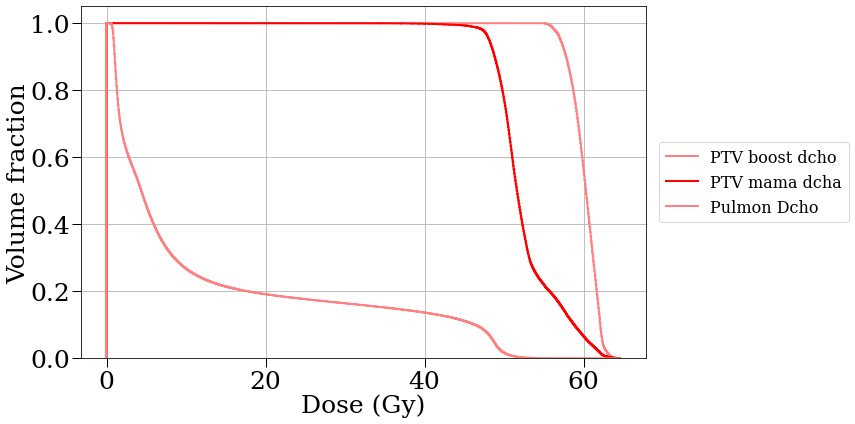

In [5]:
dose = patient.studies[0].ct_doses[plan_ID]
dose.plot_dvh([ss1[ptvboost], ss1[ptvmama], ss1[pulmonder]], bins=1000, figsize=(12,6));

In [6]:
from dicompylercore import dicomparser, dvh, dvhcalc

Identificar los archivos DICOM con las estructuras y las distribuciones de dosis

In [7]:
# Archivo DICOM de estructuras: órganos blanco y órganos de riesgo
dcm_ss = 'data/TestMamaDer001/20230116_095704/RTSTRUCT/CT/20230116_095704/RS.1.2.246.352.205.5566667512400723974.375329800850442140.dcm'
# Archivos DICOM de distribuciones de dosis
dcm_dose_mama = 'data/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/RD.1.2.246.352.221.56180825880144060698193516247443136422.dcm'
dcm_dose_boost = 'data/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/RD.1.2.246.352.221.488893207455186615011534392364350689689.dcm'
dcm_dose_suma = 'data/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/RD.1.2.246.352.221.47352446189117142439988284232660965553.dcm'
dcm_dose_SIB = 'data/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/RD.1.2.246.352.221.52708297311437444114737711031232263301.dcm'

Definir los índices de las estructuras relevantes según figuran en el archivo DICOM

In [8]:
dcm_ptvboost, dcm_ptvmama, dcm_pulmonder = 14, 15, 16

In [9]:
ptvboost_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_SIB, dcm_ptvboost)
ptvmama_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_SIB, dcm_ptvmama)
pulmonder_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_SIB, dcm_pulmonder)

In [10]:
pulmonder_dvh.describe()

Structure: Pulmon Dcho
-----
DVH Type:  cumulative, abs dose: Gy, abs volume: cm3
Volume:    1281.47 cm3
Max Dose:  47.60 Gy
Min Dose:  0.35 Gy
Mean Dose: 9.23 Gy
D100:      0.34 Gy
D98:       0.51 Gy
D95:       0.61 Gy
D2cc:      45.59 Gy


In [11]:
ptvmama_dvh.describe()

Structure: PTV mama dcha
-----
DVH Type:  cumulative, abs dose: Gy, abs volume: cm3
Volume:    766.44 cm3
Max Dose:  51.49 Gy
Min Dose:  30.31 Gy
Mean Dose: 41.52 Gy
D100:      30.30 Gy
D98:       37.68 Gy
D95:       38.60 Gy
D2cc:      50.31 Gy


In [12]:
ptvboost_dvh.describe()

Structure: PTV boost dcho
-----
DVH Type:  cumulative, abs dose: Gy, abs volume: cm3
Volume:    35.03 cm3
Max Dose:  51.49 Gy
Min Dose:  45.91 Gy
Mean Dose: 48.74 Gy
D100:      45.90 Gy
D98:       46.75 Gy
D95:       47.20 Gy
D2cc:      50.31 Gy


In [61]:
ptvboost_dvh.D5

dvh.DVHValue(48.73, 'Gy')

In [62]:
ptvmama_dvh.D5

dvh.DVHValue(47.91, 'Gy')

In [75]:
pulmonder_dvh.volume_constraint(20, dose_units='absolute').value / pulmonder_dvh.volume * 100

16.810495335960493

In [77]:
pulmonder_dvh.relative_volume.statistic('V20Gy')

dvh.DVHValue(16.810495335960493, '%')